In [ ]:
!pip install tensorflow==2.8.0
!pip install scikit-learn-extra
!pip install pip install dtaidistance
!apt-get -qq install -y graphviz && pip install pydot

from google.colab import drive
drive.mount('/content/drive')

import sys
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis


import nltk
nltk.download('punkt')

import csv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random
#from fastdtw import fastdtw
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import euclidean

import os
from sklearn.manifold import TSNE

import keras
from keras import Sequential
import tensorflow as tf
from keras.layers import Dense, Bidirectional, Dropout
from keras.layers import LSTM
#from keras.layers.recurrent import LSTM
from keras.layers.convolutional import MaxPooling1D, Conv1D
from keras.callbacks import EarlyStopping
from keras.layers import Layer
from keras import backend as K
import gc


import string
from nltk.corpus import stopwords
import gc
nltk.download("stopwords")

from keras.layers import Embedding
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings(action='ignore')
from gensim.models import Word2Vec
import gensim.downloader as api
import tensorflow_hub as hub
import pickle
import glob
import math
import statistics
import seaborn as sns
import pandas as pd
from sklearn.ensemble import IsolationForest
from scipy.stats import rankdata
import gensim
import gensim.downloader as api
#t_model = api.load('word2vec-google-news-300')
#word_vectors = t_model.vectors

#!pip install ann_visualizer
#from ann_visualizer.visualize import ann_viz;
import pydot
from keras.utils.vis_utils import plot_model

import pdb

colab_path = "/content/drive/MyDrive/Lee_sh/LEE/final_project2/" #path for the folder in the drive
colab_path0 = "/content/drive/MyDrive/Lee_sh/LEE/res700/" #path for the folder in the drive
py_file_location = "/content/drive/MyDrive/Lee_sh/LEE/final_project2"
sys.path.append(os.path.abspath(py_file_location))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def classify_text(params_obj):
    global iteration_num, sum_dicForest,sum_dic_summ,k_medoids,num_lstm,k_medoidsL,dist_mat2,dist_mat,dict_test2
    try:
        emb_dim = int(params_obj['dimensional'])
        chunk_size = int(params_obj['chunk'])
        print(chunk_size)
        batch_factor = 2
        data_batch_size = chunk_size // batch_factor
        print(chunk_size,data_batch_size)
        iter_idx = iteration_num          # iteration number
        kernel_size = [3, 6, 12]
        nb_filter = 700
        pool_size = 1
        dense_outputs = 512*4
        cat_output = 2
        learning_rate = 0.00001
        momentum = 0.9
        decay = 1
        nb_epoch = 5
        num_lstm=1000
        lstm_out = int(num_lstm * 2)
        test_size = 0.25
        pr = 0.00005 / 2
        forest_num=500
        k = 2
        pr0 = 90

        V_acc = []
        sum_dicForest = sum_dicForest
        general_dic = {}

        # get data base
        imposter_a_list = data_base_dict[params_obj["imposter_a"]]
        imposter_b_list = data_base_dict[params_obj["imposter_b"]]
        author_data_list = data_base_dict["shakespeare"]

        files = getBooksNameList("shakespeare")
        files = [file[:-4] for file in files]
        #print(files)
        # load text from file_path
        with open(params_obj['file_path'], 'r', encoding="utf-8") as file:
            text_to_classify = file.read()
            text_name = os.path.basename(file.name)
            lines = file.readlines()
            lines = [line.rstrip() for line in lines]
        author_data_list.append(text_to_classify)
        files.append(text_name[:-4])
        print(files)
        # -------- PREPROCESSING --------
        print("---------------------------")
        print("Start Preprocessing")
        imposter_a_list = preprocessing_stage(imposter_a_list, chunk_size, emb_dim)
        imposter_b_list = preprocessing_stage(imposter_b_list, chunk_size, emb_dim)
        author_data_list = preprocessing_stage(author_data_list, chunk_size, emb_dim)
        print("Finish Preprocessing")
        print("---------------------------")
        # -------------------------------

        # ----------------WORD EMBEDDING--------------------------------------------------------------
        # check if word2vec or elmo
        print("Start Word Embedding")
        if "Word2vec" in params_obj['embedding_algorithm']:
            model, total_examples = word2vec_algorithm(imposter_a_list, imposter_b_list, author_data_list, emb_dim, params_obj['embedding_algorithm'])
            model = fine_tune_word2vec_model(model, imposter_a_list, imposter_b_list, author_data_list, emb_dim, total_examples, model_type="Word2vec google")
        else:
            raise Exception("CHOOSE WORD2VEC")
            # elmo_algorithm(imposter_a_list, imposter_b_list, author_data_list, emb_dim)
        print("Finish Word Embedding")
        print("---------------------------")

        test0 = []
        for data in author_data_list:
            asdf = emm0W(data, model, data_batch_size)
            test0.append(asdf)

        imp_1 = emm0W_to_collection(imposter_a_list, model, data_batch_size)
        imp_2 = emm0W_to_collection(imposter_b_list, model, data_batch_size)

        X, Y, imp1 = create_XY(imp_1, imp_2)
        # --------------------------------------------------------------------------------------------

        # ----------------RCNNA-----------------------------------------------------------------------
        print("Start RCNNA")
        rcnna_model, history = rcnna(X, Y, emb_dim, data_batch_size, kernel_size, nb_filter,
            pool_size, dense_outputs, cat_output, learning_rate, momentum, decay,
            nb_epoch, lstm_out, test_size, 0, mod_name='model_eng', DropoutP=0.50)

        print("history['accuracy'] = ", history.history['accuracy'][-1])
        print("history['val_accuracy'] = ", history.history['val_accuracy'][-1])
        print("Finish RCNNA")
        print("---------------------------")

        V_acc.append(history.history['val_accuracy'][-1])
        np.save(colab_path0+"V_acc "+str(iteration_num)+".npy", V_acc)

        #Print figures
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig(colab_path0+"Acc "+str(iteration_num)+".png")

        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        plt.savefig(colab_path0+"Loss "+str(iteration_num)+".png")
        #plt.show()
        # --------------------------------------------------------------------------------------------

        print("---------------------------")
        print("Distance Matrix")
        dict_test = {}
        for i, file in enumerate(files):
          if i <= 49:
            dict_test[file] = np.asarray(rcnna_model.predict(np.asarray(test0[i])))[:, 0]

        del X, Y
        if 'Names' not in sum_dicForest:
            sum_dicForest['Names'] = files
            sum_labels['Names'] = files
            sum_labelsS['Names'] = files
            sum_dic_summ['Names'] = files

        dict_test2 = {}

        for key in dict_test:
            data = dict_test[key]
            list0 = [sum(g) / batch_factor for g in zip(*[iter(data)] * batch_factor)]
            dict_test2[key] = list0
            general_dic[key] = []
            general_dic[key].append(list0)
        #print(dict_test2)
        m = len(dict_test2)

        dist_mat = np.zeros([m, m])
        dist_matS=dist_mat

        for key in dict_test2.keys():
            if len(dict_test2[key]) < 2:
                dict_test2.pop(key)
                sum_dicForest.pop(key)
                sum_dic_summ.pop(key)

        for i, key1 in enumerate(dict_test2.keys()):
            for j, key2 in enumerate(dict_test2.keys()):
                #distance0, path = fastdtw(dict_test2[key1], dict_test2[key2],dist=euclidean)
                distance0 = dtw.distance(dict_test2[key1], dict_test2[key2])
                dist_mat[i, j] = distance0
        #dist_mat=(np.transpose(dist_mat) +dist_mat)*0.5
        #print(dist_mat)

        np.save(colab_path0+"Signal"+str(iteration_num)+str(num_lstm)+".npy", dict_test2)
        np.save(colab_path0+"dict_mat00 "+str(iteration_num)+".npy", dist_mat)
        #np.asarray(dist_mat).tofile(colab_path+"dist_mat"+str(iteration_num)+".csv",sep=',',format='%10.5f')
        #dist_mat0=np.concatenate((dist_mat0, dist_mat), axis=0)
        dist_matS=dist_mat
        print("Finish Distance Matrix")
        print("---------------------------")

        print("---------------------------")
        print("Start presentation")
        summa, score, y, rang = presentation(dist_mat, pr, forest_num, files, k, pr0, 'DWT', lines)
        sum_dicForest[iter_idx] = score
        sum_dic_summ[iter_idx]=summa
        print("Finish presentation")
        print("---------------------------")

        # create k-medoids model
        print("---------------------------")
        print("Start K-Medoids")

        kmedoids = KMedoids(n_clusters=2, random_state=0).fit(dist_mat)
        # update the global params for the next iteration
        sum_dicForest = sum_dicForest
        k_medoidsL = kmedoids.labels_
        #k_medoids_data = dist_mat0
        #kmedoidsS = KMedoids(n_clusters=2, random_state=0).fit(dist_matS)
        print("Finish K-Medoids")
        print("---------------------------")
        print("Move to result page")
    except Exception as e:
        print("ERROR in classify_text: ")
        print(e)
        raise Exception(e)


In [ ]:
params_obj = {
  'file_path': "",
  'imposter_a': "",
  'imposter_b': "",
  'embedding_algorithm': "",
  'dimensional': "",
  'chunk': ""
}
params_obj_list = []
iteration_num = 42

screen_dict = {}

data_base_dict = {}
sum_dic_summ = {}
sum_dicForest = {}
sum_labels={}
sum_labelsS={}
#k_medoids = []

k_medoids_data = []

#------------------------------------------------------------------------------------
#---------------------MAIN-----------------------------------------------------------
#------------------------------------------------------------------------------------
def main():
    global iteration_num, sum_dicForest,sum_dic_summ,k_medoids,num_lstm,k_medoidsL,dist_mat2,dist_mat,dict_test2
    get_shakespeare_data()    # load shakespeare data
    imposters_names = get_imposters_name_list()
    np.save(colab_path0+"names"+".npy", imposters_names)
    imposters_names0=imposters_names
    slu_list0=[]
    #print(len(imposters_names))
    for i in range(len(imposters_names)):
     for j in range(i+1,len(imposters_names)):
      slu_list0.append((i,j))


    i0=slu_list0[iteration_num-1][0]
    j0=slu_list0[iteration_num-1][1]
    #print(slu_list0[iteration_num-1])
    gr=(len(imposters_names)* (len(imposters_names)-1))//2
    #for i in range(i0,len(imposters_names)):
        #for j in range(j0, len(imposters_names)):
    while(iteration_num<(gr+1)):
            i=slu_list0[iteration_num-1][0]
            j=slu_list0[iteration_num-1][1]
            print(slu_list0[iteration_num-1])

            print(i,j)
            # load imposters data
            get_imposter_by_name(imposters_names[i])
            get_imposter_by_name(imposters_names[j])
            # params
            p = {
                'file_path': colab_path + "data_base/text to classify.txt",  # text to classify
                'imposter_a': imposters_names[i],
                'imposter_b': imposters_names[j],
                #'embedding_algorithm': "Word2vec old english",
                'embedding_algorithm': "Word2vec google",
                'dimensional': "300",
                'chunk': "100"
            }

            print('Iteration= \n',iteration_num)
            print(imposters_names0[i],'  ',imposters_names0[j],'\n')

            # start classify
            classify_text(p)


    # save report

            sum_dicForest = sum_dicForest
            sum_dic_summ=sum_dic_summ
            #sum_dicForest['Labels'] = k_medoids.labels_
            sum_labels[str(iteration_num)] = k_medoidsL
            #sum_labelsS[str(iteration_num)]=k_medoidsL
            columns = sum_dicForest.keys()
            header = columns
            with open(colab_path0+"res_report"+str(iteration_num)+str( num_lstm)+".csv", 'w', newline='') as csvfile:
             no_rows = len(sum_dicForest[list(columns)[0]])
             csvwriter = csv.writer(csvfile, delimiter=',')
             csvwriter.writerow(header)
             for row in range(no_rows):
              try:
                csvwriter.writerow([sum_dicForest[key][row] for key in header])
              except:
                print()
            with open(colab_path0+"dist_mat00"+str(iteration_num)+str( num_lstm)+".csv", 'w', newline='') as csvfile:
              np.savetxt(csvfile, dist_mat, delimiter=",")



            #np.savetxt(colab_path0+"Signal"+str(iteration_num)+str(num_lstm) +".csv", dictlist, delimiter=",")
            #np.save(colab_path0+"Signal"+str(iteration_num)+str(num_lstm)+".npy", dictlist, allow_pickle=True)
           # np.save(colab_path0+"Signal"+str(iteration_num)+str(num_lstm)+".npy",dictlist)



            with open(colab_path0+"res_report_Dist"+str(iteration_num)+str(num_lstm)+".csv", 'w', newline='') as csvfile:
             no_rows = len(sum_labels[list(columns)[0]])
             csvwriter = csv.writer(csvfile, delimiter=',')
             csvwriter.writerow(sum_labels.keys())
             for row in range(no_rows):
              try:
                csvwriter.writerow([sum_labels[key][row] for key in sum_labels.keys()])
              except:
                print()
            #csvwriter.close()
            #sum_dicForest.pop('Labels')


           # np.save(colab_path+"dist_mat2"+str(iteration_num)+".npy", dist_mat2)
            np.save(colab_path0+"dist_mat_"+str(iteration_num)+".npy", dist_mat)

            pd.DataFrame(dist_mat).to_csv(colab_path0+"dist_mat_"+str(iteration_num)+".csv")

            iteration_num += 1

#---------------------END MAIN-------------------------------------------------------
#------------------------------------------------------------------------------------


In [ ]:
def rcnna(X, Y, emb_dim, data_batch_size, kernel_size, nb_filter, pool_size, dense_outputs=256,
          cat_output=10, learning_rate=0.001, momentum=0.9, decay=0, nb_epoch=12, lstm_out=150,
          test_size=0.33, usePreL=0, mod_name='model_eng', DropoutP=0.25):
    # global model, word_model

    print('Data:')
    print(X.shape)
    print(Y.shape)

    X_train, Y_train = X, Y
    # Creating a model
    model = Sequential()
    for i in range(len(kernel_size)):
        model.add(Conv1D(filters=nb_filter, kernel_size=kernel_size[i], padding='valid', activation='relu',
                         input_shape=(data_batch_size, emb_dim)))
        model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Bidirectional(LSTM(units=lstm_out, return_sequences=True), merge_mode='concat',
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units=lstm_out, go_backwards=True)))

    #model.add(Attention(return_sequences=True))

    #model.add(BahdanauAttention(cat_output))
    model.add(Dense(dense_outputs, activation='sigmoid'))
    model.add(Dropout(DropoutP))
    model.add(Dense(cat_output, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    #ann_viz(model, view=True, title="test", filename="visualized")

    print(model.summary())
    print('Fit model...')

    Y_tmp = np.zeros([Y_train.shape[0], 2])
    Y_tmp[:, 0] = 2 - Y_train
    Y_tmp[:, 1] = Y_train - 1
    Y_train = Y_tmp

    history = model.fit(X_train, Y_train, validation_split=test_size, epochs=nb_epoch, verbose=1)
                      #  callbacks=[EarlyStopping(monitor='val_accuracy', patience=0, restore_best_weights=True)])

    del X, Y

    gc.collect()

    return model, history



In [ ]:
def create_XY(imp_1, imp_2):
    imp1 = [imp_1, imp_2]
    del imp_2
    l0 = [len(imp1[0]), len(imp1[1])]
    i1 = l0.index(max(l0))
    i2 = l0.index(min(l0))
    imp0 = []

    for kk in range(l0[i1] // l0[i2]):
        imp0 = imp0 + imp1[i2]

    imp1[i2] = imp0 + random.sample(imp1[i2], l0[i1] - len(imp0))
    imp1[0]=imp1[0]+imp1[0]+imp1[0]+imp1[0]
    imp1[1]=imp1[1]+imp1[1]+imp1[1]+imp1[1]

    imp1[0]=imp1[0]+imp1[0]
    imp1[1]=imp1[1]+imp1[1]

    Y = [1] * len(imp1[0]) + [2] * len(imp1[1])
    X = [y for x in [imp1[0], imp1[1]] for y in x]

    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y, imp1

def emm0W_to_collection(collection, model, data_batch_size):
    res_list = []
    try:
        for data in collection:
            asdf = emm0W(data, model, data_batch_size)
            for a in asdf:
                res_list.append(a)
    except Exception as e:
        res_list = []
        print(e)
    finally:
        return res_list

In [ ]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(1,), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


In [ ]:
def preprocessing_stage(collection, chunk_size, emb_dim=300):
    try:
        new_collection = []
        for text in collection:
            # split into words
            tokens = word_tokenize(text)
            # convert to lower case
            tokens = [w.lower() for w in tokens]
            # remove punctuation from each word
            table = str.maketrans('', '', string.punctuation)
            stripped = [w.translate(table) for w in tokens]
            # remove remaining tokens that are not alphabetic
            words = [word for word in stripped if word.isalpha()]
            # filter out stop words
            stop_words = set(stopwords.words('english'))
            words = [w for w in words if not w in stop_words]

            new_collection.append(words)
        return new_collection
    except Exception as e:
        print("ERROR in preprocessing_stage: " + e.args[0])
        return None

def emm0W(impost_1, t_model, data_batch_size):
    impost_1_np_3D = []
    for token in impost_1:
        if token in t_model.wv:
            impost_1_np_3D.append(t_model.wv[token])

    impost_1_np_3D = np.asarray(impost_1_np_3D)
    bloks = len(impost_1_np_3D)//data_batch_size
    X_1 = []
    for kk in range(bloks):
        X_1.append(impost_1_np_3D[kk*data_batch_size:(kk+1)*data_batch_size ,  :])
    X_1 = np.asarray(X_1)
    del impost_1_np_3D
    gc.collect()
    return X_1

def word2vec_algorithm(imposter_data1, imposter_data2, author_data, dimension, model_type="Word2vec google"):
  try:
    global colab_path

    model_2 = Word2Vec(vector_size=dimension, min_count=5)
    model_2.build_vocab(imposter_data1 + imposter_data2)
    total_examples = model_2.corpus_count
    if model_type == "Word2vec google":
      t_model = api.load('word2vec-google-news-300')
      word_vectors = t_model.vectors
      model = t_model
      model_2.build_vocab([list(model.key_to_index.keys())], update=True)
    else:
      with open(colab_path + "/word-embedding-models/1800-vocab.pkl", 'rb') as f:
          word = pickle.load(f)
      word_vectors = np.load(colab_path + "/word-embedding-models/" + "1800-w.npy")
      model_2.build_vocab(word, update=True)

    model_2.intersect_word2vec_format = word_vectors
    model_2.train(imposter_data1 + imposter_data2 + author_data, total_examples=total_examples, epochs=20)

    # Add an additional layer for fine-tuning
    model_2.build_vocab([list(model_2.wv.key_to_index.keys())], update=True)
    model_2.train(imposter_data1 + imposter_data2 + author_data, total_examples=total_examples, epochs=10)

    return model_2, total_examples
  except Exception as e:
    print("ERROR in word2vec_algorithm: " + e.args[0])
    return None

def fine_tune_word2vec_model(model, imposter_data1, imposter_data2, author_data, dimension, total_examples=2000, model_type="Word2vec google"):
  try:
    # Fine tune the model
    for epoch in range(10):
      model.train(imposter_data1 + imposter_data2 + author_data, total_examples=total_examples, epochs=1)

    return model
  except Exception as e:
    print("ERROR in fine_tune_word2vec_model: " + e.args[0])
    return None

def get_shakespeare_data():
    global data_base_dict
    try:
      path = colab_path + "data_base"
      file_list = glob.glob(os.path.join(path, "shakespeare", "*.txt"))
      data_list = create_data_list(file_list)
      if 'text to classify' in set(data_list):
        data_list.remove('text to classify')
      data_base_dict['shakespeare'] = data_list
    except Exception as e:
      print("Error at get_shakespeare_data: " + e.args[0])

def get_imposter_by_name(name):
    global data_base_dict
    try:
      path = colab_path + "data_base/imposters"
      file_list = glob.glob(os.path.join(path, name, "*.txt"))
      data_list = create_data_list(file_list)
      data_base_dict[name] = data_list
    except Exception as e:
      print("Error at get_imposter_by_name: " + e.args[0])

def create_data_list(file_list):
    try:
        data = []
        for file_path in file_list:
            with open(file_path, "r", encoding='utf-8', errors='ignore') as f_input:
                data.append(f_input.read().replace('\n', ' '))
        return data
    except Exception as e:
        print("Error at create_data_list: " + e.args[0])
        return []

def get_imposters_name_list():
    try:
        path = colab_path + "data_base/imposters"
        names = os.listdir(path)
        return names
    except Exception as e:
        print("Error at get_imposters_name_list: " + str(e))
        return []

def getBooksNameList(name):
    mypath = colab_path + "data_base/"
    if name == "shakespeare" or name == "Shakespeare":
        mypath = mypath + "shakespeare"
        onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
    else:
        mypath = mypath + "imposters"
        onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
    for file in onlyfiles:
        name, ext = os.path.splitext(file)
        if ext != ".txt":
            onlyfiles.remove(file)
    return onlyfiles


def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def calc_frac(a):
    """a function that returns the fraction of ones in each column or row"""
    s = []
    for a0 in a:
     s.append(1-np.array(((a0 > a).sum())/len(a)))
    return(s)

def presentation(dist_mat, pr, forest_num, files, k, pr0, str0, lines):

    clf = IsolationForest(n_estimators=forest_num, warm_start=True)

    clf.set_params(n_estimators=forest_num)  # add 10 more trees
    clf.fit(dist_mat)
    y_pred_train = clf.predict(dist_mat)

    score = clf.decision_function(dist_mat)
    index0 = np.where(score < pr)
    labels = np.zeros(len(score))
    labels[index0] = 1
    print('\n++++++++++++++++++++++++++++++++++++')
    print(str0, '\n')
    fl = []
    for indd in index0[0]:
        print(files[indd], indd)
        fl.append(files[indd])
    print('\n++++++++++++++++++++++++++++++++++++')
    rang = len(intersection(fl, lines))

    #summa = [np.sum(np.sort(s)[1:k+1])/k for s in dist_mat]
    summa = [np.sum(s) for s in dist_mat]
    summa = summa/sum(summa)
    index0 = np.where(summa > np.percentile(summa, pr0))
    for indd in index0[0]:
        print(files[indd], indd)
    print('\n++++++++++++++++++++++++++++++++++++')
   #return rankdata(summa), score, y_pred_train, rang
    return summa, score, y_pred_train, rang


(1, 21)
1 21
Iteration= 
 42
Arthur C Clarke    TH 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS AND CRESSIDA', 'THE TRAGEDY OF TITUS ANDRONICUS', 'MEASURE FOR MEASURE', 'THE TRAGEDY OF ANTONY AND CLEOPATRA', 'THE TEMPEST', 'PERICLES PRINCE OF TYRE', 'THE TRAGEDY OF KING LEAR', 'Venus and Adonis', 'THE MERRY WIVES OF WINDSOR', 'THE TRAGEDY OF OTHELLO MOOR OF VENICE', 'THE TRAGEDY OF HAMLET PRINCE OF DENMARK', 'THE TWO GENTLEMEN OF VERONA', 'KING HENRY V', 'THE TRAGEDY OF CORIOLANUS', 'THE LIFE OF TIMON OF ATHENS', 'THE TRAGEDY OF JULIUS CAESAR', 'THE TRAGEDY OF ROMEO AND JULIET', 'THE TRAGEDY OF MACBETH', 'THE TAMING OF THE SHREW', 'Taming of the Shrew', 'Merchant of Venice', 'KING EDWARD III by Shakespeare', 'The Comedy of Errors', 'Fair Em by Shakespeare', 'King Henry IV, Part 1', 'KING RICH

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(53856, 50, 300)
(53856,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 700)           630700    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 700)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 700)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 700)           5880700   
                            

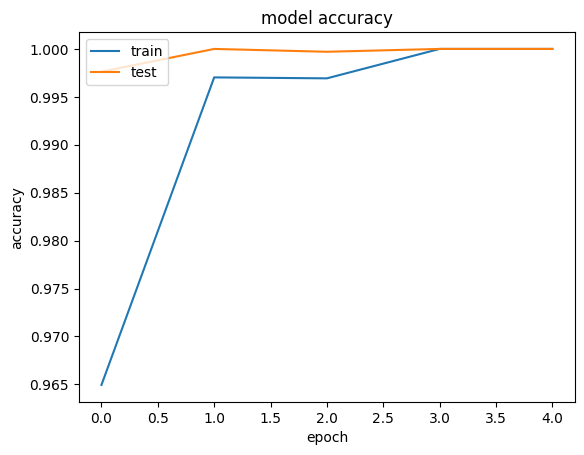

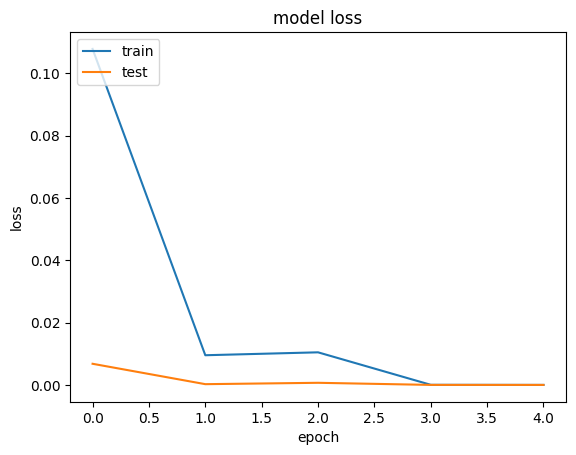

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

CYMBELINE 1
KING HENRY VIII 2
THE WINTERS TALE 9
THE TRAGEDY OF ANTONY AND CLEOPATRA 13
THE TEMPEST 14
THE TRAGEDY OF OTHELLO MOOR OF VENICE 19
THE TRAGEDY OF HAMLET PRINCE OF DENMARK 20
KING HENRY V 22
THE TRAGEDY OF CORIOLANUS 23
THE LIFE OF TIMON OF ATHENS 24
THE TRAGEDY OF JULIUS CAESAR 25
THE TRAGEDY OF MACBETH 27
The Comedy of Errors 32
King Henry IV, Part 1 34
Sir John Oldcastle by Shakespeare 38
The Puritaine Widdow by Shakespeare 43
The Two Noble Kinsmen by Shakespeare 45
KING HENRY VI part I 48

++++++++++++++++++++++++++++++++++++
CYMBELINE 1
THE TRAGEDY OF ANTONY AND CLEOPATRA 13
KING HENRY V 22
THE TRAGEDY OF MACBETH 27
The Puritaine Widdow by Shakespeare 43

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Fini

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(20480, 50, 300)
(20480,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 48, 700)           630700    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 48, 700)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 43, 700)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 32, 700)           5880700   
                          

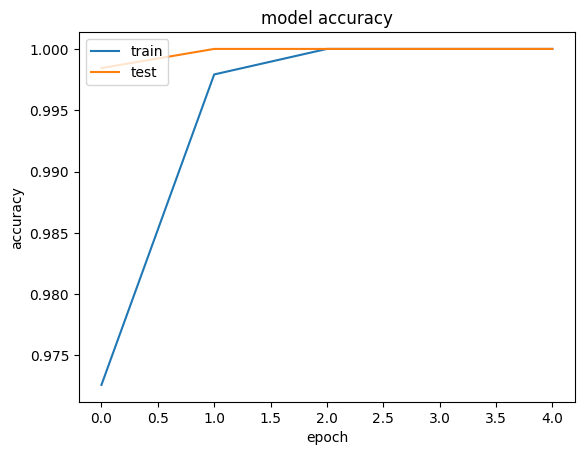

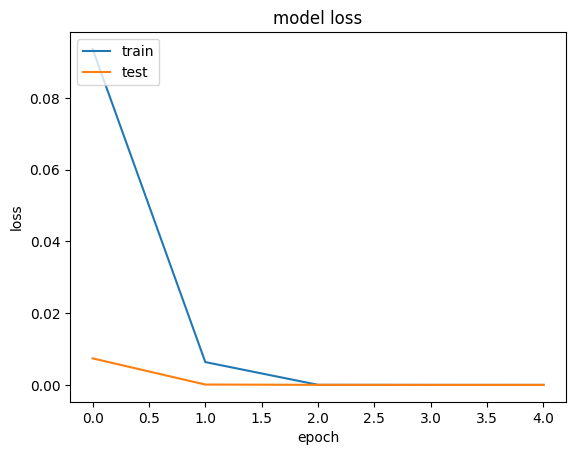

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

CYMBELINE 1
A LOVERS COMPLAINT 8
THE HISTORY OF TROILUS AND CRESSIDA 10
PERICLES PRINCE OF TYRE 15
Venus and Adonis 17
THE TRAGEDY OF HAMLET PRINCE OF DENMARK 20
KING HENRY V 22
THE LIFE OF TIMON OF ATHENS 24
THE TRAGEDY OF MACBETH 27
Love_s Labour_s Lost 36
The Life and Death of the Lord Cromwell by Shakespeare 40
The Puritaine Widdow by Shakespeare 43
A Yorkshire Tragedy by Shakespeare 46

++++++++++++++++++++++++++++++++++++
PERICLES PRINCE OF TYRE 15
KING HENRY V 22
The Life and Death of the Lord Cromwell by Shakespeare 40
The Puritaine Widdow by Shakespeare 43
The Two Noble Kinsmen by Shakespeare 45

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2,

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(48048, 50, 300)
(48048,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 48, 700)           630700    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 48, 700)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 43, 700)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 32, 700)           5880700   
                          

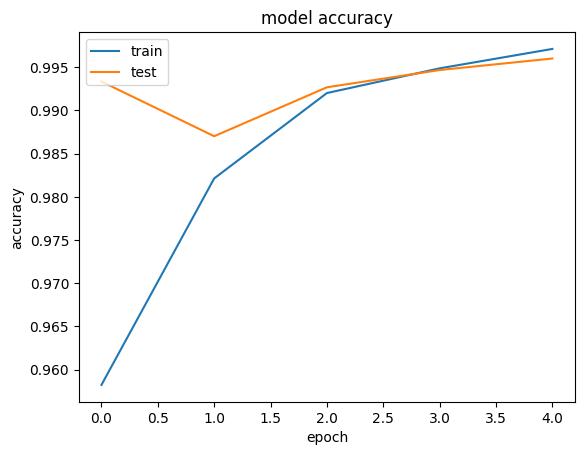

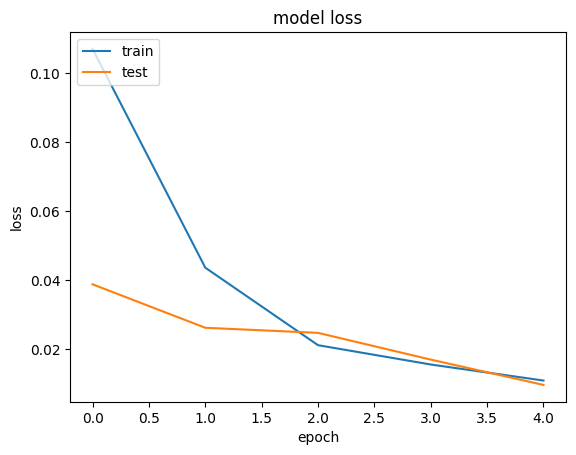

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

KING JOHN 6
THE WINTERS TALE 9
THE MERRY WIVES OF WINDSOR 18
THE TRAGEDY OF OTHELLO MOOR OF VENICE 19
The Puritaine Widdow by Shakespeare 43

++++++++++++++++++++++++++++++++++++
KING JOHN 6
THE WINTERS TALE 9
THE MERRY WIVES OF WINDSOR 18
THE TRAGEDY OF OTHELLO MOOR OF VENICE 19
The Puritaine Widdow by Shakespeare 43

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2, 4)
2 4
Iteration= 
 45
00    ben Jonson 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS AND CRESS

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(48272, 50, 300)
(48272,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 48, 700)           630700    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 48, 700)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 32, 700)           5880700   
                          

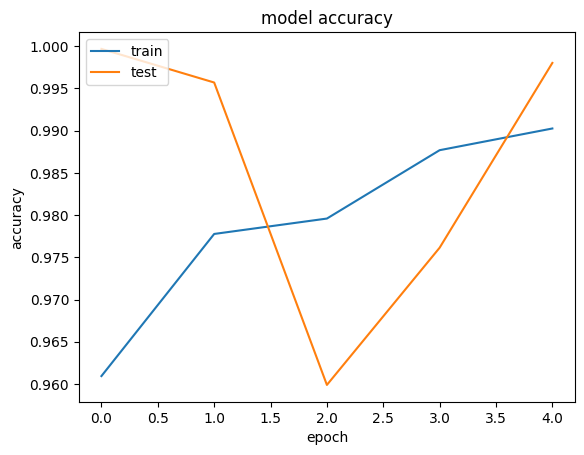

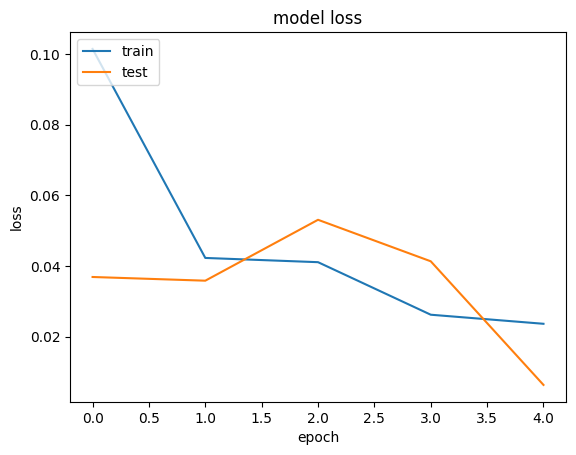

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

KING HENRY VIII 2
A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
THE WINTERS TALE 9
MEASURE FOR MEASURE 12
Venus and Adonis 17
THE TRAGEDY OF OTHELLO MOOR OF VENICE 19
THE TRAGEDY OF MACBETH 27
Taming of the Shrew 29
Merchant of Venice 30
Fair Em by Shakespeare 33
King Henry IV, Part 1 34
Love_s Labour_s Lost 36
MUCH ADO ABOUT NOTHING 37
The Puritaine Widdow by Shakespeare 43
THE RAPE OF LUCRECE 44
A Yorkshire Tragedy by Shakespeare 46
Arden of Feversham 47
Locrine Mucedorus by Shakespeare 49

++++++++++++++++++++++++++++++++++++
KING HENRY VIII 2
A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
THE WINTERS TALE 9
Taming of the Shrew 29

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to re

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(48096, 50, 300)
(48096,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 48, 700)           630700    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 48, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 32, 700)           5880700   
                          

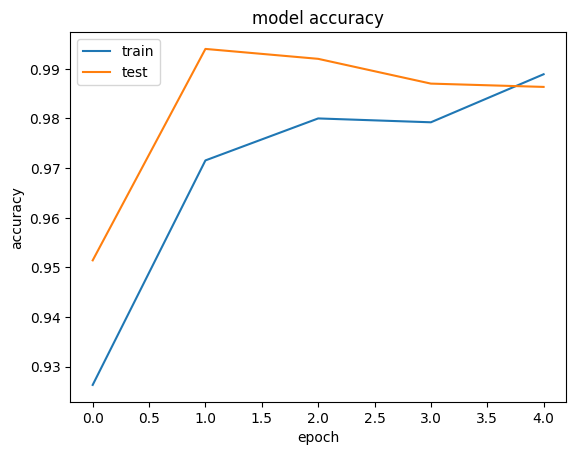

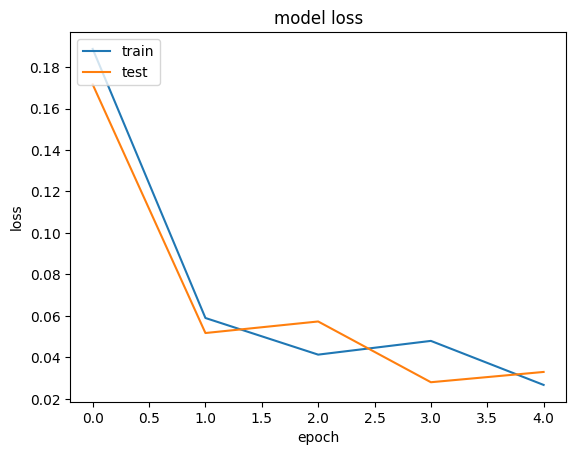

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
A LOVERS COMPLAINT 8
KING HENRY V 22
Fair Em by Shakespeare 33

++++++++++++++++++++++++++++++++++++
A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
A LOVERS COMPLAINT 8
KING HENRY V 22
Fair Em by Shakespeare 33

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2, 6)
2 6
Iteration= 
 47
00    Christopher Marlowe 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS AND CRESSIDA', 'THE TRAGEDY OF TITUS ANDRONICUS', 'MEASURE FOR MEASURE', 'TH

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(47856, 50, 300)
(47856,)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 48, 700)           630700    
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 48, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 32, 700)           5880700   
                          

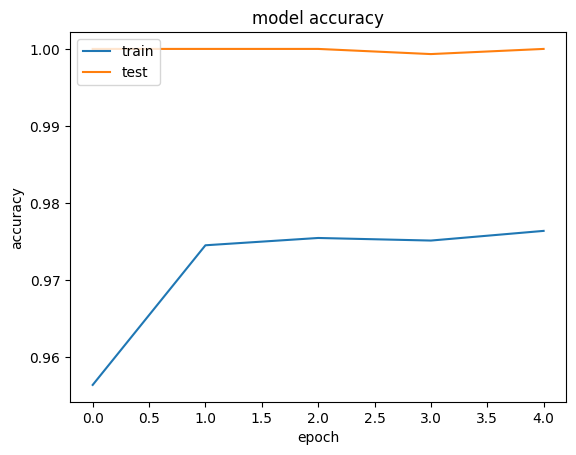

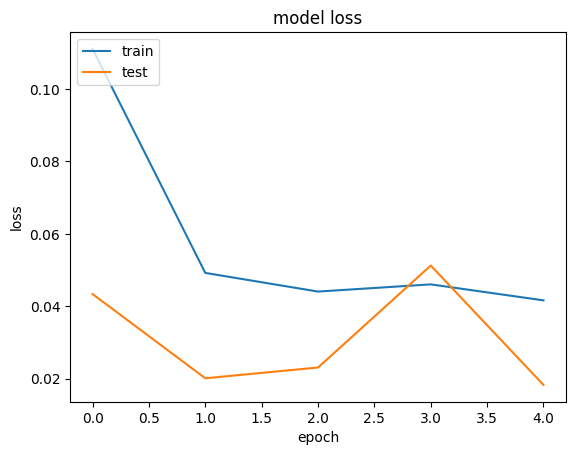

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

KING JOHN 6
THE MERRY WIVES OF WINDSOR 18
THE TRAGEDY OF OTHELLO MOOR OF VENICE 19
The Comedy of Errors 32
The Puritaine Widdow by Shakespeare 43

++++++++++++++++++++++++++++++++++++
KING JOHN 6
THE MERRY WIVES OF WINDSOR 18
THE TRAGEDY OF OTHELLO MOOR OF VENICE 19
The Comedy of Errors 32
The Puritaine Widdow by Shakespeare 43

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2, 7)
2 7
Iteration= 
 48
00    Galsworthy 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(47808, 50, 300)
(47808,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 48, 700)           630700    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 48, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 32, 700)           5880700   
                          

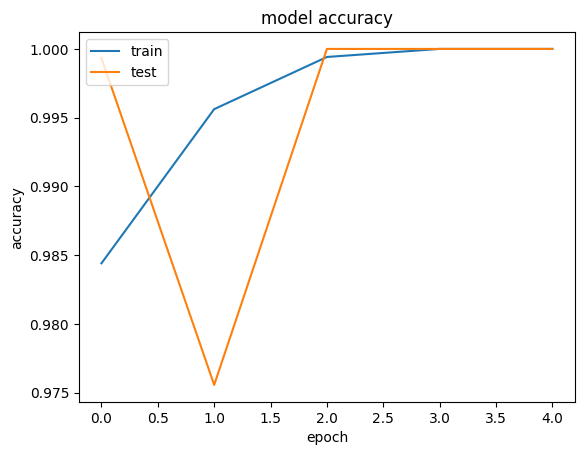

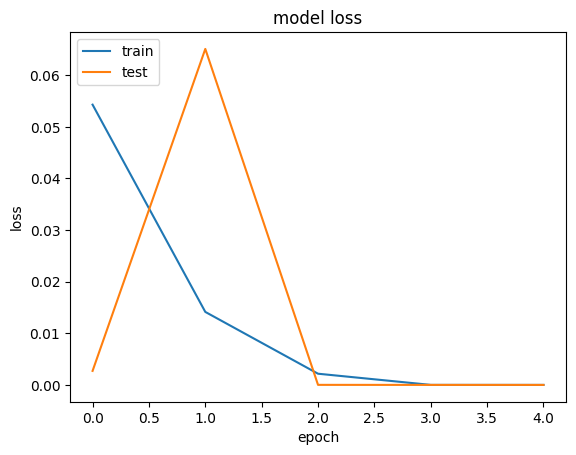

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
A LOVERS COMPLAINT 8
THE TRAGEDY OF ROMEO AND JULIET 26
A Yorkshire Tragedy by Shakespeare 46

++++++++++++++++++++++++++++++++++++
A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
KING HENRY V 22
THE TRAGEDY OF ROMEO AND JULIET 26
A Yorkshire Tragedy by Shakespeare 46

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2, 8)
2 8
Iteration= 
 49
00    EG 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS AND CRESSIDA', 'THE TRAGEDY OF TITUS

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(48160, 50, 300)
(48160,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 48, 700)           630700    
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 48, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 32, 700)           5880700   
                          

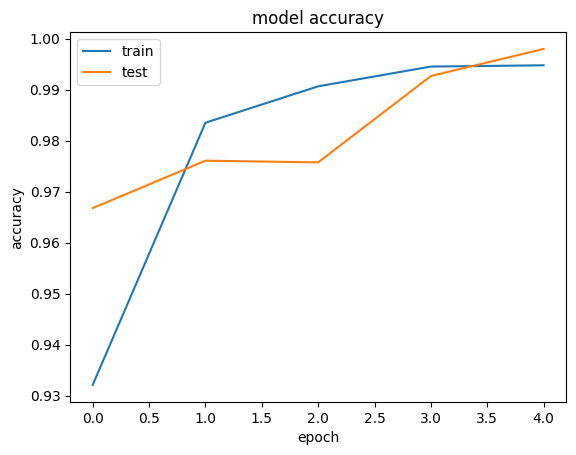

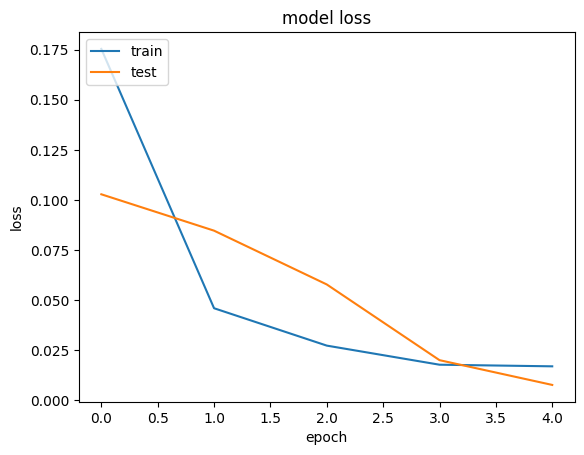

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

KING JOHN 6
A LOVERS COMPLAINT 8
THE TRAGEDY OF ANTONY AND CLEOPATRA 13
Venus and Adonis 17
A Yorkshire Tragedy by Shakespeare 46

++++++++++++++++++++++++++++++++++++
KING JOHN 6
A LOVERS COMPLAINT 8
THE TRAGEDY OF ANTONY AND CLEOPATRA 13
Venus and Adonis 17
The Puritaine Widdow by Shakespeare 43

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2, 9)
2 9
Iteration= 
 50
00    Francis Bacon 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS AND CRESSIDA', 'THE TRAGEDY

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(47904, 50, 300)
(47904,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 48, 700)           630700    
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 48, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 32, 700)           5880700   
                          

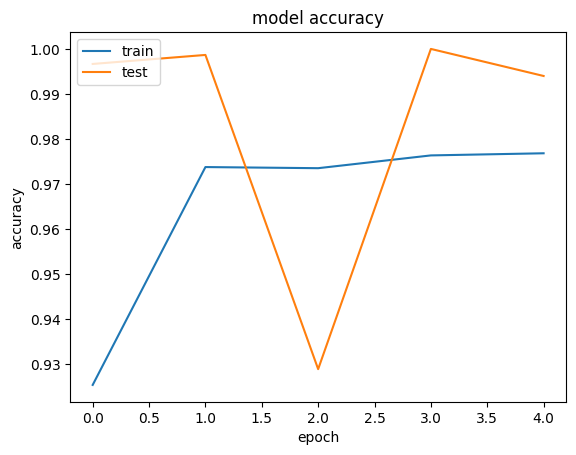

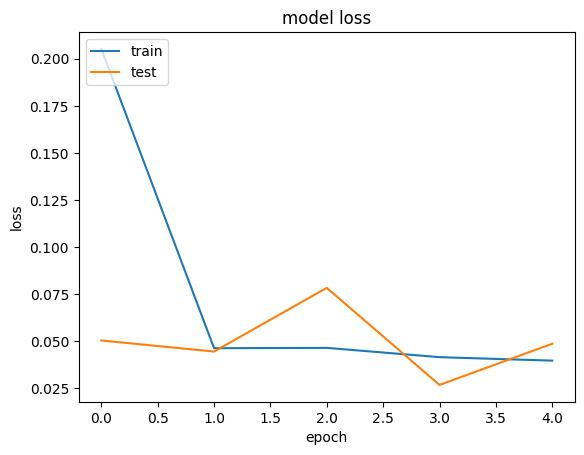

---------------------------
Distance Matrix
Finish Distance Matrix
---------------------------
---------------------------
Start presentation

++++++++++++++++++++++++++++++++++++
DWT 

KING JOHN 6
A LOVERS COMPLAINT 8
KING HENRY V 22
KING EDWARD III by Shakespeare 31
A Yorkshire Tragedy by Shakespeare 46

++++++++++++++++++++++++++++++++++++
KING HENRY VI Part III 0
A MIDSUMMER NIGHT_S DREAM 4
KING JOHN 6
KING HENRY V 22
KING EDWARD III by Shakespeare 31

++++++++++++++++++++++++++++++++++++
Finish presentation
---------------------------
---------------------------
Start K-Medoids
Finish K-Medoids
---------------------------
Move to result page




(2, 10)
2 10
Iteration= 
 51
00    dryD 

100
100 50
['KING HENRY VI Part III', 'CYMBELINE', 'KING HENRY VIII', 'KING HENRY VI Part II', 'A MIDSUMMER NIGHT_S DREAM', 'AS YOU LIKE IT', 'KING JOHN', 'KING RICHARD II', 'A LOVERS COMPLAINT', 'THE WINTERS TALE', 'THE HISTORY OF TROILUS AND CRESSIDA', 'THE TRAGEDY OF TITUS ANDRONICUS', 'MEASURE 

Finish Word Embedding
---------------------------
Start RCNNA
Data:
(58640, 50, 300)
(58640,)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 48, 700)           630700    
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 48, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 43, 700)           2940700   
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 43, 700)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 32, 700)           5880700   
                          

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

In [ ]:
if __name__ == "__main__":
    main()